### MRI Brain Tumour Segmentation using U-Net Deep Learning Model

References:
- https://github.com/adityajn105/brain-tumor-segmentation-unet/blob/master/brain_tumor_segmentation.ipynb

In [1]:
import matplotlib.pyplot as plt
from utils import *
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization, Flatten, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
""" Dataset Preparations """
# Parameters
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32
NUM_CLASSES = 4 

# Create ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,      # Random rotation up to 10 degrees
    width_shift_range=0.1,  # Random horizontal shift by up to 10% of image width
    height_shift_range=0.1, # Random vertical shift by up to 10% of image height
    shear_range=0.2,        # Random shearing by up to 20%
    zoom_range=0.1,         # Random zooming by up to 10%
    # zoom_range=[.9,1.1],    # Random zooming by up to 10% or down to 10%
    horizontal_flip=True,   # Random horizontal flipping
    fill_mode='nearest',    # Fill mode for pixels outside the input boundaries
    validation_split=0.2    # Split data into training and validation
)

# Create ImageDataGenerator for validation data (without augmentation)
valid_datagen = ImageDataGenerator(validation_split=0.2)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=19032024
)

# Create validation generator
validation_generator = valid_datagen.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=19032024
)

# Check the shape of your training data
for images, labels in train_generator:
    print("Shape of images batch:", images.shape)
    print("Shape of labels batch:", labels.shape)
    break


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Shape of images batch: (32, 128, 128, 3)
Shape of labels batch: (32, 4)


In [3]:
# Get class names
class_names = list(train_generator.class_indices.keys())
print("Training classes:", class_names)
class_names = list(validation_generator.class_indices.keys())
print("Validation classes:", class_names)

Training classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Validation classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


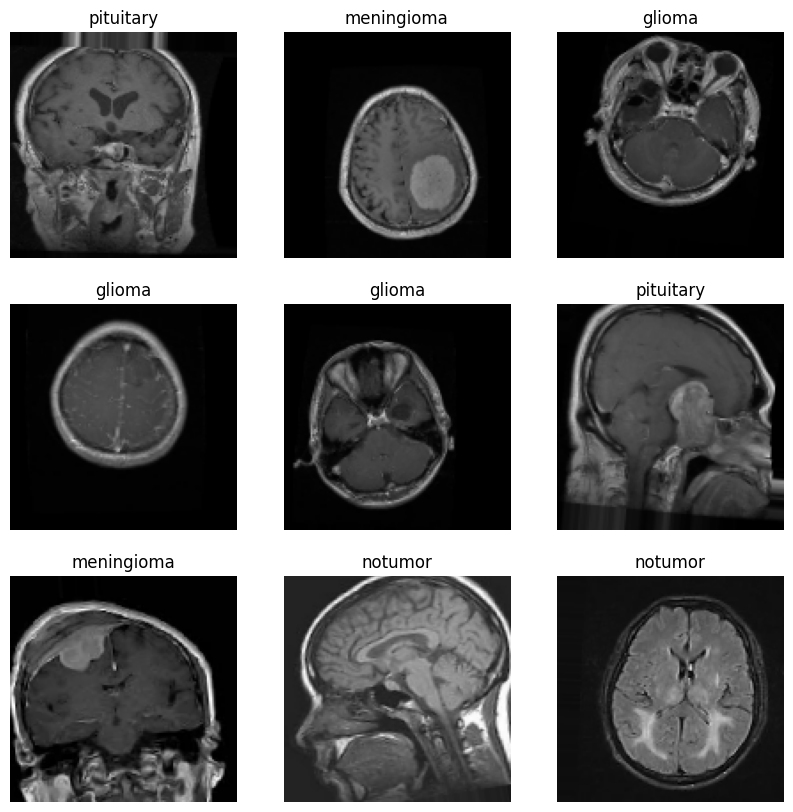

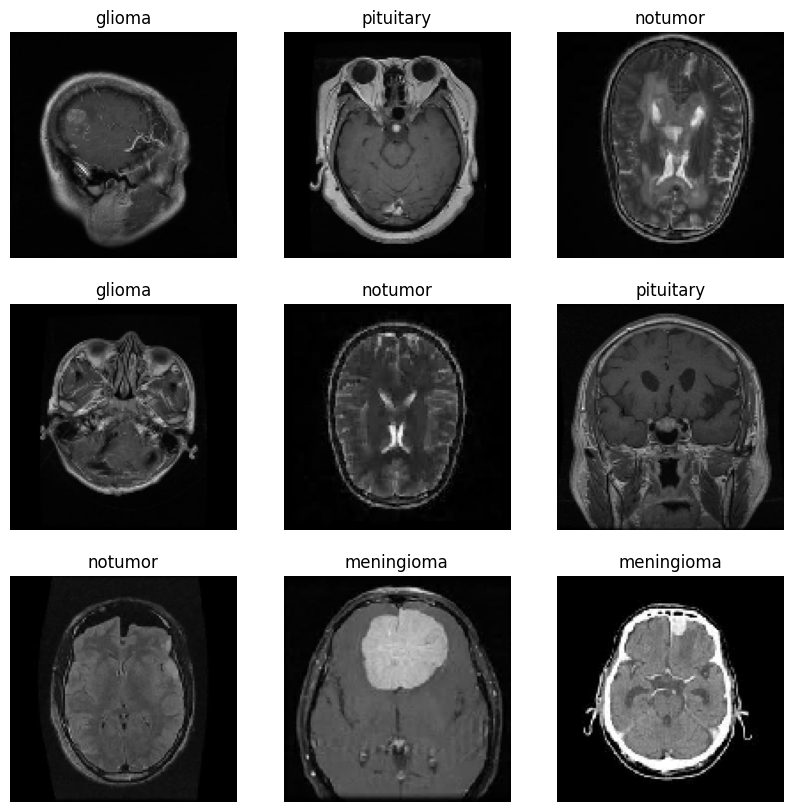

In [4]:
# Preview training dataset
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[labels[i].argmax()])
    plt.axis("off")

# Preview validation dataset
plt.figure(figsize=(10, 10))
images, labels = next(validation_generator)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[labels[i].argmax()])
    plt.axis("off")

In [5]:
""" Create Model """
IMG_DIM = (128,128,3)
NUM_CLASSES = 4

def conv2d_block(input_tensor, n_filters, kernel_size=(3,3), name="contraction"):
    "Add 2 conv layers"
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
               padding='same', activation="relu", name=name+'_1')(input_tensor)
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
               padding='same', activation="relu", name=name+'_2')(x)
    return x
  
inp = Input(shape=IMG_DIM)

# Encoder
d1 = conv2d_block(inp, 64, name="contraction_1")
p1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d1)
p1 = BatchNormalization(momentum=0.8)(p1)
p1 = Dropout(0.1)(p1)

d2 = conv2d_block(p1, 128, name="contraction_2")
p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d2)
p2 = BatchNormalization(momentum=0.8)(p2)
p2 = Dropout(0.1)(p2)

d3 = conv2d_block(p2, 256, name="contraction_3")
p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d3)
p3 = BatchNormalization(momentum=0.8)(p3)
p3 = Dropout(0.1)(p3)

d4 = conv2d_block(p3, 512, name="contraction_4")
p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d4)
p4 = BatchNormalization(momentum=0.8)(p4)
p4 = Dropout(0.1)(p4)

d5 = conv2d_block(p4, 512, name="contraction_5")

# Decoder
u1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(d5)
u1 = concatenate([u1, d4])
u1 = Dropout(0.1)(u1)
c1 = conv2d_block(u1, 512, name="expansion_1")

u2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c1)
u2 = concatenate([u2, d3])
u2 = Dropout(0.1)(u2)
c2 = conv2d_block(u2, 256, name="expansion_2")

u3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c2)
u3 = concatenate([u3, d2])
u3 = Dropout(0.1)(u3)
c3 = conv2d_block(u3, 128, name="expansion_3")

u4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c3)
u4 = concatenate([u4, d1])
u4 = Dropout(0.1)(u4)
c4 = conv2d_block(u4, 64, name="expansion_4")

# Final classification layer
flattened = Flatten()(c4)
out = Dense(NUM_CLASSES, activation='softmax', name="output")(flattened)

unet = Model(inp, out)

unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_1_1     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_1_2     │ (None, 128, 128,  │     36,928 │ contraction_1_1[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ contraction_1_2[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_2_1     │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_2_2     │ (None, 64, 64,    │    147,584 │ contraction_2_1[… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ contraction_2_2[… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_3_1     │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_3_2     │ (None, 32, 32,    │    590,080 │ contraction_3_1[… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ contraction_3_2[… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_4_1     │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0] 

 Total params: 26,913,924 (102.67 MB)

 Trainable params: 26,912,004 (102.66 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [6]:
# Create callbacks
model_checkpoint = ModelCheckpoint('./models/unet_best_checkpoint.keras', save_best_only=True, 
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

# Define callback list
callback_list = [early_stopping, reduceLR, model_checkpoint]

# Train the model
hist = unet.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=callback_list)

# Export latest model
unet.save(MODEL_FILE)

# Load the best model
unet = load_model('./models/unet_best_checkpoint.keras')

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2249 - loss: 3390.4529
Epoch 1: val_loss improved from inf to 31.89246, saving model to ./models/unet_best_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 79s 6s/step - accuracy: 0.2256 - loss: 3290.2500 - val_accuracy: 0.3646 - val_loss: 31.8925 - learning_rate: 0.0010
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3395 - loss: 17.0050
Epoch 2: val_loss improved from 31.89246 to 1.99122, saving model to ./models/unet_best_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 76s 6s/step - accuracy: 0.3398 - loss: 16.5296 - val_accuracy: 0.4375 - val_loss: 1.9912 - learning_rate: 0.0010
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4205 - loss: 2.0668
Epoch 3: val_loss improved from 1.99122 to 1.29257, saving model to ./models/unet_best_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 76s 6s/step - accuracy: 0.4204 - loss: 2.0382 - val_accuracy: 0.4583 - val_loss: 1.2926 - learning_rate: 0.0010
Epoch 4/30
12/12 ━━━━━━━━━

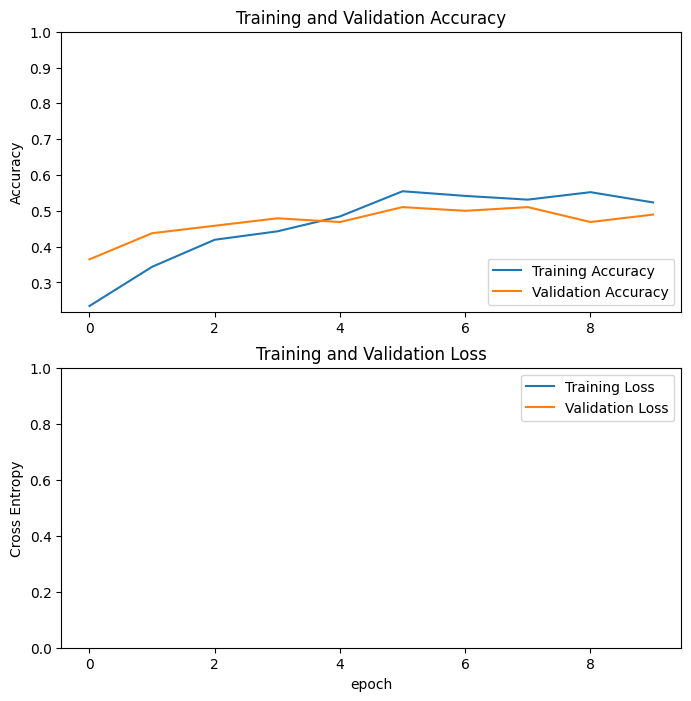

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4727 - loss: 1.2185
Test Accuracy : 0.46875
Test Loss : 1.2165690660476685
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4922 - loss: 1.1937
Validation Accuracy: 0.47


In [7]:
""" Preliminary Model Performance """
# View training metrics across epochs
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test metrics
loss, accuracy = unet.evaluate(validation_generator)
print('Test Accuracy :', accuracy)
print('Test Loss :', loss)

# Evaluate the model
loss, accuracy = unet.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.2f}')


In [8]:
""" Model Performance """
# Load images and labels
images, labels, class_names = load_data(DATASET_FOLDER)

# Load the trained model
model = keras.models.load_model(MODEL_FILE)

# Train-Test split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=1234)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
# Initialise predictions
list_train_pred = []
list_test_pred = []

for image_path in x_train:
    list_train_pred.append(predict_class(image_path, model, class_names, (128, 128), verbose_output=1))
    
for image_path in x_test:
    print(image_path)
    list_test_pred.append(predict_class(image_path, model, class_names, (128, 128), verbose_output=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━

In [11]:
# Get model's training performance
training_results = classifier_metrics(list(y_train), list_train_pred, print_results=True)

Accuracy: 0.046875
Precision: 0.05087620124364047
Recall: 0.0375
F1 Score: 0.04216836169990602
Matthews Correlation Coefficient (MCC): -0.09967452114156113
Cohen's Kappa: -0.07726269315673284
Hamming Loss: 0.953125

Confusion Matrix:
 [[ 0  0  0  0  0]
 [87  1  5  3  0]
 [67 13 12  4  0]
 [21 10 60  5  0]
 [32  5 10 49  0]]

Classification Report:
               precision    recall  f1-score   support

   .DS_Store       0.00      0.00      0.00         0
      glioma       0.03      0.01      0.02        96
  meningioma       0.14      0.12      0.13        96
     notumor       0.08      0.05      0.06        96
   pituitary       0.00      0.00      0.00        96

    accuracy                           0.05       384
   macro avg       0.05      0.04      0.04       384
weighted avg       0.06      0.05      0.05       384





/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

In [12]:
# Get model's test performance
test_results = classifier_metrics(list(y_test), list_test_pred, print_results=True)

Accuracy: 0.041666666666666664
Precision: 0.039037433155080216
Recall: 0.03333333333333333
F1 Score: 0.03584305408271474
Matthews Correlation Coefficient (MCC): -0.1128042768973104
Cohen's Kappa: -0.08875739644970415
Hamming Loss: 0.9583333333333334

Confusion Matrix:
 [[ 0  0  0  0  0]
 [23  0  1  0  0]
 [15  2  3  4  0]
 [ 3  3 17  1  0]
 [ 9  2  1 12  0]]

Classification Report:
               precision    recall  f1-score   support

   .DS_Store       0.00      0.00      0.00         0
      glioma       0.00      0.00      0.00        24
  meningioma       0.14      0.12      0.13        24
     notumor       0.06      0.04      0.05        24
   pituitary       0.00      0.00      0.00        24

    accuracy                           0.04        96
   macro avg       0.04      0.03      0.04        96
weighted avg       0.05      0.04      0.04        96





/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms